## TOY PROJECT 04 - 네이버 영화 감성분석
네이버 영화 사이트의 영화 리뷰 감성을 분석합니다. 


### 1. 라이브러리 및 데이터 불러오기
데이터 핸들링을 위해 `pandas`,   
한국어 자연어처리를 위해 `konlpy`,    
__를 위해 `gensim` 라이브러리를 활용합니다.

In [3]:
def print_lib_ver(lib):
    print(f"{lib.__name__}: {lib.__version__}")

import numpy as np
import pandas as pd
import konlpy
import gensim

import tensorflow as tf
import matplotlib.pyplot as plt

print_lib_ver(pd)
print_lib_ver(konlpy)
print_lib_ver(gensim)
print_lib_ver(tf)


pandas: 1.3.3
konlpy: 0.5.2
gensim: 4.1.2
tensorflow: 2.6.0


In [4]:
import os

def data_path(data_name):
    return f"{os.getcwd()}/data/{data_name}"

train_data = pd.read_table(data_path('ratings_train.txt'))
test_data = pd.read_table(data_path('ratings_test.txt'))

print(len(train_data), len(test_data))
train_data.head(3)


150000 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 2. 데이터 로더 - 형태소 전환 및 단어 인덱스로 변환

In [42]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 훈련 데이터의 중복&결측 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) 
    train_data = train_data.dropna(how = 'any') 
    
    # 테스트 데이터의 중복&결측 데이터 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 훈련 데이터 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    # 테스트 데이터 토큰화 및 불용어 제거
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 단어 텍스트 리스트를 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # 정제된 X_train, X_test 데이터
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # 각각 X_train, y_train, X_test, y_test, word_to_index → 전처리 후 데이터 반환   
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}


### 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터 셋 내부 문장 길이 분포 확인  
- 적절한 최대 문장 길이 지정  
- keras ~ pad_sequence를 활용한 패딩 추가 


In [6]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


#### 적절한 최대 문장 길이는 무엇을 기준으로 판단하는가?

In [7]:
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen: ', maxlen)
print(f'전체 문장의 {round(np.sum(num_tokens < max_tokens) / len(num_tokens), 5) * 100}%가 maxlen 설정값 이내에 포함됩니다.')


pad_sequences maxlen:  54
전체 문장의 97.209%가 maxlen 설정값 이내에 포함됩니다.


#### pad_sequence로 padding 적용

In [44]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 54)


### 4. 모델 구성 및 validation set 구성  

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

#### 4.1. CNN

In [52]:
model_cnn = tf.keras.Sequential(name = "model_cnn")
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9 

#### 4.2. CNN - Global Maxpooling

In [51]:
model_cnnglobal = tf.keras.Sequential(name = "model_cnn_global")
model_cnnglobal.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnnglobal.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnnglobal.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnnglobal.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnnglobal.summary()

Model: "model_cnn_global"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 4.3. RNN

In [50]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)


model_rnn = tf.keras.Sequential(name='model_rnn')
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()


Model: "model_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시


In [78]:
# validation set 10000건 분리
X_val = X_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 136182 건
partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 54)
(136182,)


In [79]:
epochs = 20
models = [model_cnn, model_cnnglobal, model_rnn]

list_history = []
for model in models:
    model.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])
    
    print("==== ==== ==== ==== ==== ==== ==== ====")
    print(f"model name: {model._name} fit start!!")
    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)
    
    list_history.append(history)
    

==== ==== ==== ==== ==== ==== ==== ====
model name: model_cnn fit start!!
Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2074 - accuracy: 0.9407 - val_loss: 0.4795 - val_accuracy: 0.8319
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1506 - accuracy: 0.9526 - val_loss: 0.4945 - val_accuracy: 0.8305
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1243 - accuracy: 0.9617 - val_loss: 0.5329 - val_accuracy: 0.8274
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1045 - accuracy: 0.9682 - val_loss: 0.5912 - val_accuracy: 0.8280
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0893 - accuracy: 0.9728 - val_loss: 0.6324 - val_accuracy: 0.8225
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.0773 - accuracy: 0.9766 - val_loss: 0.7014 - val_accuracy: 0.8253
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 

In [80]:
dict_history = {f'model {i+1}': dict(history.history) for i, history in enumerate(list_history)}
dict_history

{'model 1': {'loss': [0.20735780894756317,
   0.1506299376487732,
   0.1243237629532814,
   0.10451369732618332,
   0.0892816036939621,
   0.07727459818124771,
   0.06763991713523865,
   0.0606984905898571,
   0.05416037142276764,
   0.049811434000730515,
   0.0459340363740921,
   0.04308614134788513,
   0.0412629134953022,
   0.0399002879858017,
   0.038629598915576935,
   0.03653697669506073,
   0.03411947563290596,
   0.03249696269631386,
   0.032409925013780594,
   0.03216072544455528],
  'accuracy': [0.9406749606132507,
   0.9525707960128784,
   0.9617130160331726,
   0.968218982219696,
   0.9727864265441895,
   0.976575493812561,
   0.9795787930488586,
   0.9816495776176453,
   0.9838892221450806,
   0.9852550029754639,
   0.986422598361969,
   0.9868999123573303,
   0.9875901341438293,
   0.9878104329109192,
   0.9878250956535339,
   0.9884859919548035,
   0.9896461963653564,
   0.9899399280548096,
   0.9898003935813904,
   0.989433228969574],
  'val_loss': [0.4794645607471466,


### 6. Loss, Accuracy 그래프 시각화


In [81]:
dict_history.keys()

dict_keys(['model 1', 'model 2', 'model 3'])

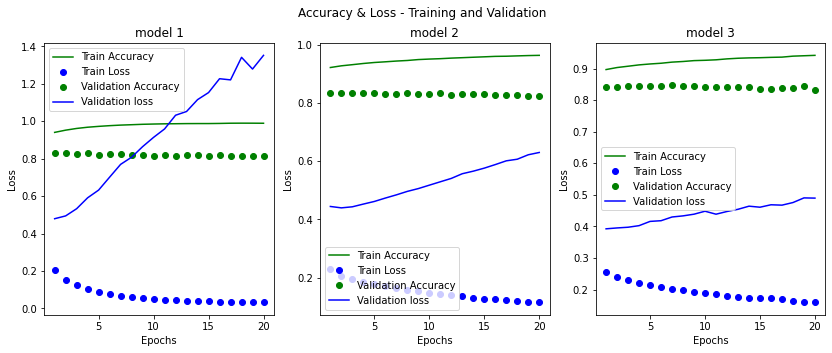

In [86]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

plt.suptitle("Accuracy & Loss - Training and Validation")

for ax, key in zip(axes, dict_history.keys()):    
    history = dict_history[key]
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    ax.plot(epochs, acc, 'g', label='Train Accuracy')  
    ax.plot(epochs, loss, 'bo', label='Train Loss')
    ax.plot(epochs, val_acc, 'go', label = 'Validation Accuracy')
    ax.plot(epochs, val_loss, 'b', label='Validation loss')
    
    ax.set_title(key)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    

plt.show()

### 7. 학습된 Embedding Layer 분석


### 8. 한국어 word2vec 임베딩 활용해 성능 개선